Neste exercício, resolvemos a Equação de Poisson 1D usando Physics-Informed Neural Networks (PINN) com a biblioteca DeepXDE.

In [8]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt
from deepxde.backend import torch


In [9]:
# Geometria do problema: domínio [0,1]
geom = dde.geometry.Interval(0, 1)

# Condições de contorno de Dirichlet: u(0)=0 e u(1)=0
def bc(x, on_boundary):
    return on_boundary

bc_dirichlet = dde.DirichletBC(geom, lambda x: 0, bc)


In [10]:
pi = np.pi

def pde(x, y):
    dy_xx = dde.grad.hessian(y, x)
    return -dy_xx - (pi ** 2) * torch.sin(pi * x)


In [11]:
data = dde.data.PDE(
    geom,
    pde,
    [bc_dirichlet],
    num_domain=1000,
    num_boundary=100,
    solution=None,
    num_test=1000
)


In [12]:
# Rede Neural: 2 camadas escondidas, 50 neurônios cada
net = dde.maps.FNN([1] + [50] * 2 + [1], activation="tanh", kernel_initializer="Glorot normal")


In [13]:
model = dde.Model(data, net)
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(epochs=5000)


Compiling model...
'compile' took 0.000279 s

Training model...

Step      Train loss              Test loss               Test metric
0         [4.44e+01, 1.15e-03]    [4.89e+01, 1.15e-03]    []  
1000      [1.61e-03, 3.23e-08]    [1.34e-03, 3.23e-08]    []  
2000      [8.93e-04, 3.57e-07]    [7.30e-04, 3.57e-07]    []  
3000      [1.75e-04, 1.84e-08]    [1.35e-04, 1.84e-08]    []  
4000      [1.03e-04, 4.74e-09]    [9.20e-05, 4.74e-09]    []  
5000      [8.75e-05, 1.00e-09]    [8.04e-05, 1.00e-09]    []  

Best model at step 5000:
  train loss: 8.75e-05
  test loss: 8.04e-05
  test metric: []

'train' took 33.149545 s



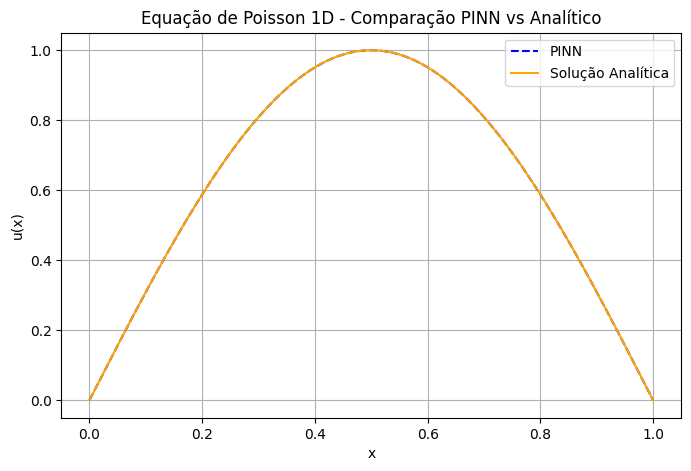

In [14]:
# Pontos de teste uniformemente distribuídos
X = geom.uniform_points(1000, True)

# Predição da PINN
y_pred = model.predict(X)

# Solução analítica correta
u_analitico = np.sin(np.pi * X)

# Plot do resultado
plt.figure(figsize=(8,5))
plt.plot(X, y_pred, 'b--', label="PINN")
plt.plot(X, u_analitico, 'orange', label="Solução Analítica")
plt.title("Equação de Poisson 1D - Comparação PINN vs Analítico")
plt.xlabel("x")
plt.ylabel("u(x)")
plt.legend()
plt.grid()
plt.savefig('../imagens/Poisson_1D.png')
plt.show()
